In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F


from ray import tune
from ray.tune.examples.mnist_pytorch import get_data_loaders, train, test

In [2]:
import numpy as np
import random
import sys
import pickle
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import accuracy_score
import seaborn as sns

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skorch import NeuralNetRegressor

from sklearn.model_selection import GridSearchCV
from collections import defaultdict
from sklearn import metrics
import pandas as pd

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
print(device)  

cpu


### load pre-process data

In [3]:
class GTZANDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx][0]
        y = self.data[idx][1]
        
        if self.transform:
            x = self.transform(x)
        
        x = torch.Tensor(x)

        return (x, y)

batch_size = 1


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

raw_trainset = pickle.load(open('GTZAN.train', 'rb'))
trainset = GTZANDataset(raw_trainset)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

raw_testset = pickle.load(open('GTZAN.test', 'rb'))
testset = GTZANDataset(raw_testset)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)


classes = ('blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock')

In [4]:
class Net(nn.Module):  
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(20*32*161, 100) # Get the vector of the layer right before the final fc layer and plot tfidf
        self.fc2 = nn.Linear(100, 10) 
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 20*32*161)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [5]:
def train(net, opt, trainloader, loss_func): 
   
    avg_losses = []   # Avg. losses.
   
    epochs = 10       # Total epochs.
    print_freq = 100  # Print frequency.

    try:
        for epoch in range(epochs):  # Loop over the dataset multiple times.
    
            running_loss = 0.0 
            for i, data in enumerate(trainloader, 0):

                # Get the inputs.
                inputs, labels = data
                
                # Move the inputs to the specified device.
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the parameter gradients.
                opt.zero_grad()

                # Forward step.
                outputs = net(inputs)
                loss = loss_func(outputs, labels)

                # Backward step.
  
                loss.backward()
                # Optimization step (update the parameters).
   
                opt.step()
                # Print statistics.
    
                running_loss += loss.item()
                if i % print_freq == print_freq - 1: # Print every several mini-batches.
    
                    avg_loss = running_loss / print_freq
#                     print('[epoch: {}, i: {:5d}] avg mini-batch loss_net: {:.3f}'.format(
#                         epoch, i, avg_loss))
                    
    
                    avg_losses.append(avg_loss)
   
                    running_loss = 0.0

        print('Finished Training.')
    except KeyboardInterrupt:
        print('Halted Training')

In [6]:
def test(net, testloader):
    # Get test accuracy.
    correct_net = 0
   
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs_net = net(images)
            
            _, predicted_net = torch.max(outputs_net.data, 1)
            
            total += labels.size(0)
            correct_net += (predicted_net == labels).sum().item()
            

#     print('Net: Accuracy of the network on the 10000 test images: %d %%' % (
#         100 * correct_net / total))
    return (100 * correct_net / total)

In [7]:
def train_test(config):
    model = Net()
    optimizer = optim.SGD(
        model.parameters(), lr=config["lr"], momentum=config["momentum"])
    loss_func = nn.CrossEntropyLoss()  
    for i in range(3):
        train(model, optimizer, trainloader, loss_func)
        acc = test(model, testloader)
        tune.track.log(mean_accuracy=acc)

In [8]:
search_space = {
    "lr": tune.choice([0.001, 0.01, 0.1]),
    "momentum": tune.uniform(0.1, 0.9)
}
analysis = tune.run(train_test, config=search_space)

2020-06-09 13:43:17,550	INFO resource_spec.py:212 -- Starting Ray with 4.54 GiB memory available for workers and up to 2.29 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-06-09 13:43:18,220	INFO services.py:1170 -- View the Ray dashboard at localhost:8265
2020-06-09 13:43:25,183	WARNING worker.py:1090 -- The dashboard on node dsmlp-jupyter-rol044 failed with the following error:
Traceback (most recent call last):
  File "/home/rol044/.local/lib/python3.7/site-packages/ray/dashboard/dashboard.py", line 1220, in <module>
    dashboard.run()
  File "/home/rol044/.local/lib/python3.7/site-packages/ray/dashboard/dashboard.py", line 594, in run
    aiohttp.web.run_app(self.app, host=self.host, port=self.port)
  File "/home/rol044/.local/lib/python3.7/site-packages/aiohttp/web.py", line 433, in run_app
    reuse_port=reuse_port))
  File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 584, in run_until_complete
    return

Trial name,status,loc,lr,momentum
train_test_00000,RUNNING,,0.001,0.647844


(pid=3057) 2020-06-09 13:43:42,451	INFO trainable.py:217 -- Getting current IP.
(pid=3057) Finished Training.
Result for train_test_00000:
  date: 2020-06-09_14-16-54
  done: false
  experiment_id: 8e1a53f40cf34a4186d823aac51d4bbc
  experiment_tag: 0_lr=0.001,momentum=0.64784
  hostname: dsmlp-jupyter-rol044
  iterations_since_restore: 1
  mean_accuracy: 33.0
  node_ip: 10.36.0.2
  pid: 3057
  time_since_restore: 1991.6068246364594
  time_this_iter_s: 1991.6068246364594
  time_total_s: 1991.6068246364594
  timestamp: 1591737414
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00000'
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_test_00000,RUNNING,10.36.0.2:3057,0.001,0.647844,33,0,1991.61


(pid=3057) Finished Training.
Result for train_test_00000:
  date: 2020-06-09_14-49-50
  done: false
  experiment_id: 8e1a53f40cf34a4186d823aac51d4bbc
  experiment_tag: 0_lr=0.001,momentum=0.64784
  hostname: dsmlp-jupyter-rol044
  iterations_since_restore: 2
  mean_accuracy: 39.5
  node_ip: 10.36.0.2
  pid: 3057
  time_since_restore: 3968.453826904297
  time_this_iter_s: 1976.8470022678375
  time_total_s: 3968.453826904297
  timestamp: 1591739390
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '00000'
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_test_00000,RUNNING,10.36.0.2:3057,0.001,0.647844,39.5,1,3968.45


(pid=3057) Finished Training.
Result for train_test_00000:
  date: 2020-06-09_15-22-02
  done: false
  experiment_id: 8e1a53f40cf34a4186d823aac51d4bbc
  experiment_tag: 0_lr=0.001,momentum=0.64784
  hostname: dsmlp-jupyter-rol044
  iterations_since_restore: 3
  mean_accuracy: 39.0
  node_ip: 10.36.0.2
  pid: 3057
  time_since_restore: 5900.243527889252
  time_this_iter_s: 1931.7897009849548
  time_total_s: 5900.243527889252
  timestamp: 1591741322
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: '00000'
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_test_00000,RUNNING,10.36.0.2:3057,0.001,0.647844,39,2,5900.24


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_test_00000,TERMINATED,,0.001,0.647844,39,2,5900.24


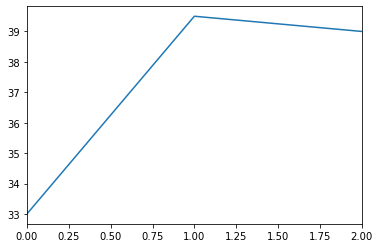

In [9]:
dfs = analysis.trial_dataframes

# Plot by epoch
ax = None  # This plots everything on the same plot
for d in dfs.values():
    ax = d.mean_accuracy.plot(ax=ax, legend=False)